<b>Import Library</b>

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal as signal

<b>Read Image</b>

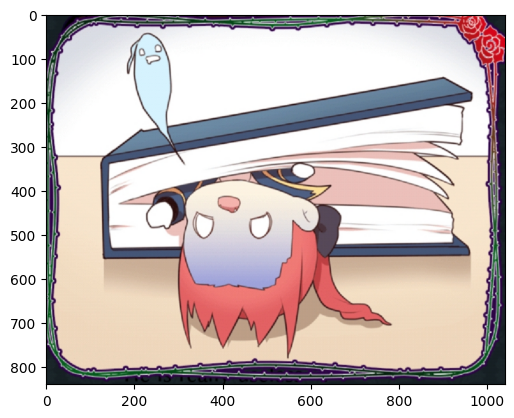

In [71]:
img = cv2.imread('test.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

<b>Show Imanges for Comparison</b>

In [72]:
def showImg(img, processedImg):
    _, axs = plt.subplots(1, 2, figsize=(10, 5))

    ax1 = axs[0]
    ax2 = axs[1]
    
    ax1.imshow(img, cmap="gray")
    ax1.set_title("OpenCV")

    ax2.imshow(processedImg, cmap="gray")
    ax2.set_title("Self-implement")

    plt.tight_layout()
    plt.show()

<b>Sobel Edge Detection using OpenCV</b>

In [73]:
Gx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
Gy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)

magnitude = np.sqrt(Gx**2 + Gy**2)

magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
magnitude = np.where(magnitude < 50, 0, 255)
magnitude = magnitude.astype(np.uint8)

<b>Sobel Edge Detection Algorithm</b>

In [74]:
def gradientEdgeDetection (img, T):
    #Sobel operator
    kernel_x = np.array([[1/4, 0, -1/4],
                      [1/2, 0, -1/2],
                      [1/4, 0, -1/4]])
    
    kernel_y = np.array([[-1/4, -1/2, -1/4],
                         [0, 0, 0],
                         [1/4, 1/2, 1/4]])
    
    grad_x = signal.convolve2d(img, kernel_x, mode= 'same')
    grad_y = signal.convolve2d(img, kernel_y, mode= 'same')
    
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    #BEI
    img_1 = np.where(magnitude < T, 0, 255)
    
    return Image.fromarray(np.uint8(img_1))

grad = gradientEdgeDetection(img_gray, 50)

<b>Show Images</b>

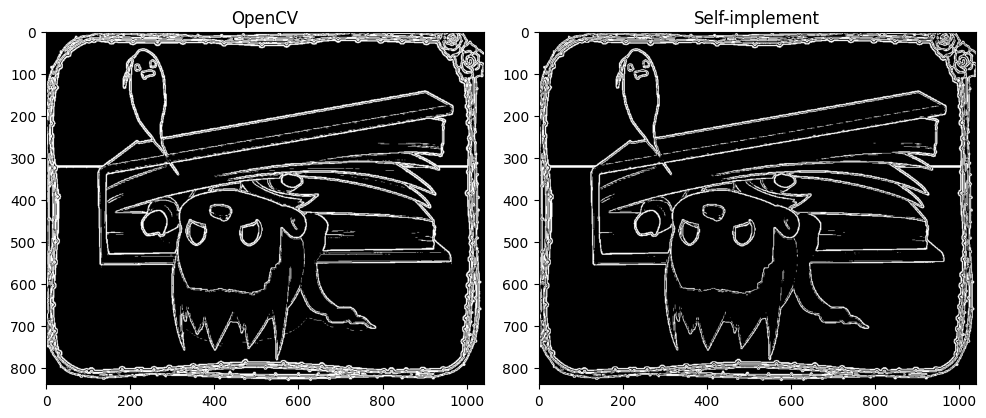

In [75]:
showImg(magnitude, grad)

<b>Laplace Edge Detection using OpenCV</b>

In [76]:
laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)

<b>Laplace Edge Detection Algorithm</b>

In [77]:
def laplaceEdgeDetection(img, T):
    kernel = np.array([[0, 1, 0],
                    [1, -4, 1],
                    [0, 1, 0]])
    dst = signal.convolve2d(img, kernel, mode= 'same', boundary='symm')
    
    res = np.zeros_like(img)
    #Zero-crossing function
    for x in range(dst.shape[0] - 1):
        for y in range(dst.shape[1] - 1):
            count = 0
            if dst[x, y] * dst[x + 1, y] < 0:
                count = count + 1
            elif dst[x, y] * dst[x, y + 1] <0:
                count = count + 1
            if count == 1 and np.abs(dst[x, y]) > T:
                res[x, y] = 255
    return Image.fromarray(np.clip(res, 0, 255).astype(np.uint8))

img_laplace = laplaceEdgeDetection(img_gray, 50)

<b>Show Images</b>

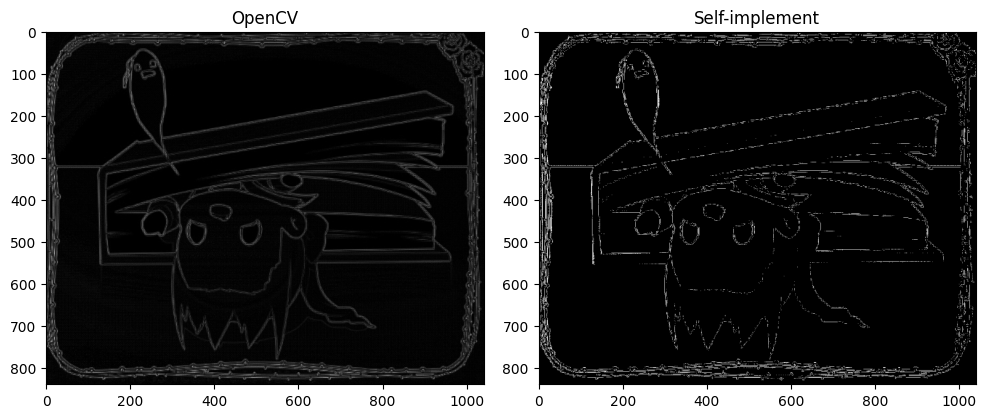

In [78]:
showImg(laplacian, img_laplace)

<b>Laplace of Gaussian using OpenCV</b>

In [79]:
img_blur = cv2.GaussianBlur(img, (3, 3), 0)
img_blur = np.uint8(img_blur)
img_LoG = cv2.Laplacian(img_blur, cv2.CV_64F)
img_LoG = cv2.convertScaleAbs(img_LoG)

<b>Laplace of Gaussian Algorithm</b>

In [80]:
def LoG(sigma, x, y):
    laplace = -1/(np.pi*sigma**4)*((x**2+y**2)/(2*sigma**2) - 1)*np.exp(-(x**2+y**2)/(2*sigma**2))
    return laplace

def LoG_discrete(sigma, n):
    l = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            l[i,j] = LoG(sigma, (i-(n-1)/2),(j-(n-1)/2))
    return l

def laplaceOfGaussian(img, sigma, T):
    #Calculate the kernel and apply convolution
    blur_filter = np.round(LoG_discrete(sigma, 5)*(-40/LoG(sigma,0,0)))
    dst = signal.convolve2d(img, blur_filter, mode= 'same', boundary='symm')
    
    res = np.zeros_like(img, dtype= float)
    
    #Zero-crossing function with threshold
    for x in range(dst.shape[0] - 1):
        for y in range(dst.shape[1] - 1):
            count = 0
            if dst[x, y] * dst[x + 1, y] < 0:
                count = count + 1
            elif dst[x, y] * dst[x, y + 1] <0:
                count = count + 1
            if count == 1 and np.abs(dst[x, y]) > T:
                res[x, y] = 255
    return Image.fromarray(np.clip(res, 0, 255).astype(np.uint8))
    
LoG_img = laplaceOfGaussian(img_gray, 1.0, 50)

<b>Show Images</b>

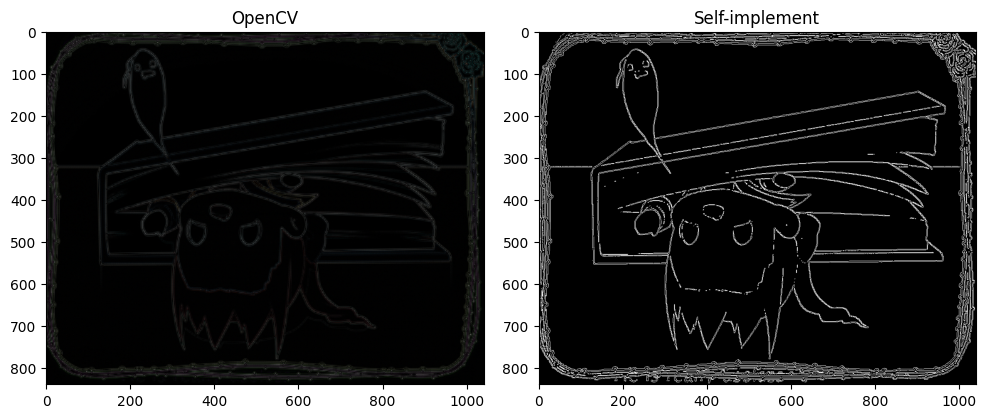

In [81]:
showImg(img_LoG, LoG_img)

<b>Canny Edge Detection using OpenCV</b>

In [82]:
img_Canny = cv2.Canny(img, 50, 150)

<b>Canny Edge Detection Algorithm</b>

In [83]:
def cannyEdgeDetection(img, T0, T1):
    #Gaussian Blur
    img_blur = cv2.GaussianBlur(img, (3, 3), 0)
    
    #Sobel operator convolution
    kernel_x = np.array([[1/4, 0, -1/4],
                      [1/2, 0, -1/2],
                      [1/4, 0, -1/4]])
    
    kernel_y = np.array([[-1/4, -1/2, -1/4],
                         [0, 0, 0],
                         [1/4, 1/2, 1/4]])
    
    grad_x = signal.convolve2d(img_blur, kernel_x, mode= 'same')
    grad_y = signal.convolve2d(img_blur, kernel_y, mode= 'same')
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = magnitude/ magnitude.max() * 255
    
    theta = np.arctan2(grad_y, grad_x)
    
    res = np.zeros_like(img_blur, dtype= float)
    theta = theta * 180/ np.pi
    theta[theta < 0] += 180
    
    #Non-maximum suppression
    for i in range(1, res.shape[0] - 1):
        for j in range(1, res.shape[1] - 1):
            r = 255
            q = 255
            if (0 <= theta[i, j] and theta[i, j] < 22.5) or (157.5 <= theta[i, j] and theta[i, j] <= 180):
                r = magnitude[i, j - 1]
                q = magnitude[i, j + 1]
            elif 22.5 <= theta[i, j] and theta[i, j] < 67.5:
                r = magnitude[i - 1, j + 1]
                q = magnitude[i + 1, j - 1]
            elif 67.5 <= theta[i, j] and theta[i, j] < 112.5:
                r = magnitude[i - 1, j]
                q = magnitude[i + 1, j]
            elif 112.5 <= theta[i, j] and theta[i, j] < 157.5:
                r = magnitude[i - 1, j - 1]
                q = magnitude[i + 1, j + 1]
                
            if magnitude[i, j] >= r and magnitude[i, j] >= q:
                res[i, j] = magnitude[i, j]
            else:
                res[i, j] = 0
    
    out_img = np.zeros_like(res, dtype= np.int32)
    weak = 128
    strong = 255
    
    strong_i, strong_j = np.where(res >= T1)
    weak_i, weak_j = np.where((T0 <= res) & (res <= T1))
    
    out_img[strong_i, strong_j] = strong
    out_img[weak_i, weak_j] = weak
    
    #Hysteresis with double threshold
    for i in range(1, out_img.shape[0] - 1):
        for j in range(1, out_img.shape[1] - 1):
            if(out_img[i, j] == weak):
                if out_img[i + 1, j] == strong or out_img[i, j + 1] == strong or \
                    out_img[i - 1, j] == strong or out_img[i, j - 1] == strong or \
                        out_img[i + 1, j - 1] == strong or out_img[i + 1, j + 1] == strong or\
                            out_img[i - 1, j - 1] == strong or out_img[i - 1, j + 1] == strong:
                                out_img[i, j] = strong
            else:
                out_img[i, j] = 0
    return Image.fromarray(np.uint8(out_img))

canny = cannyEdgeDetection(img_gray, 50, 150)

<b>Show Images</b>

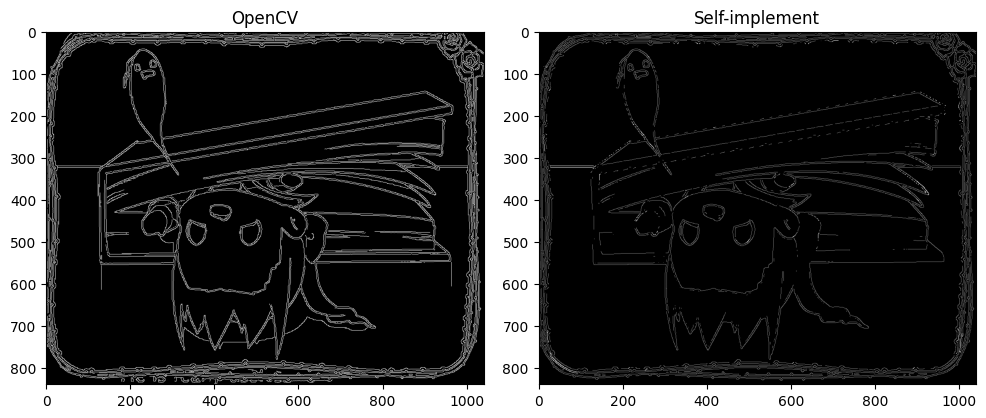

In [84]:
showImg(img_Canny, canny)